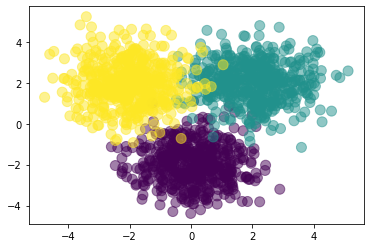

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#generate random data
n = 500
D = 2 # dimensionality of input
M = 10 # hidden layer size
K = 3 # number of classes

X1 = np.random.randn(n, 2) + np.array([0, -2])
X2 = np.random.randn(n, 2) + np.array([2, 2])
X3 = np.random.randn(n, 2) + np.array([-2, 2])
X = np.vstack([X1, X2, X3])

Y = np.array([0]*n + [1]*n + [2]*n)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, alpha=0.5)
plt.show()

N = len(Y)
Y_ind = np.zeros((N, K))
for i in range(N):
    Y_ind[i, Y[i]] = 1

Iteration  0 /50: Cost:  71.19425646119096  Error:  0.05
Iteration  10 /50: Cost:  35.23236488864017  Error:  0.043333333333333335
Iteration  20 /50: Cost:  34.9098468842884  Error:  0.04
Iteration  30 /50: Cost:  35.12252333677762  Error:  0.043333333333333335
Iteration  40 /50: Cost:  35.32251197525949  Error:  0.043333333333333335
Iteration  50 /50: Cost:  35.465435682750574  Error:  0.043333333333333335


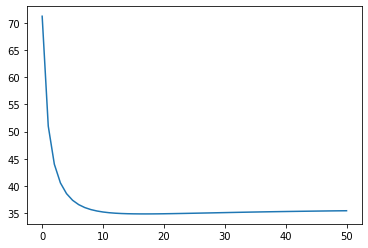

In [0]:
from sklearn.model_selection import train_test_split
import theano.tensor as T
import theano

def error_rate(p, t):
    return np.mean(p != t)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_ind, test_size=0.2)

lr = 0.001
reg = 0.01
m = 0.99

batch_size = 250
n_batches = N//batch_size

W1_init = np.random.randn(D, M) / np.sqrt(D)
W2_init = np.random.randn(M, K) / np.sqrt(M)
b1_init = np.zeros(M)
b2_init = np.zeros(K)

#data as theano variables
thX = T.matrix('X')
thT = T.matrix('T')

#weights as theano variables
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')

#velocities as theano variables
vW1 = theano.shared(0, 'vW1')
vW2 = theano.shared(0, 'vW2')
vb1 = theano.shared(0, 'vb1')
vb2 = theano.shared(0, 'vb2')

#model definition
thZ = T.nnet.relu(thX.dot(W1) + b1)
thY = T.nnet.softmax(thZ.dot(W2) + b2)

#expressions
cost = -((thT * T.log(thY)).sum() + reg*((W1**2).sum() + (W2**2).sum() + (b1**2).sum() + (b2**2).sum()))
prediction = T.argmax(thY, axis=1)
targets = T.argmax(thT, axis=1)

vW1 = m*vW1 - lr * T.grad(cost, W1)
vW2 = m*vW2 - lr * T.grad(cost, W2)
vb1 = m*vb1 - lr * T.grad(cost, b1)
vb2 = m*vb2 - lr * T.grad(cost, b2)

update_W1 = W1 + vW1
update_b1 = b1 + vb1
update_W2 = W2 + vW2
update_b2 = b2 + vb2

#functions
train = theano.function(
    inputs=[thX, thT],
    updates=[(W1, update_W1), (W2, update_W2), (b1, update_b1), (b2, update_b2)]
)

get_prediction = theano.function(
    inputs=[thX, thT],
    outputs=[cost, prediction, targets]
)

#main training loop
costs = []
for i in range(51):
    for j in range(n_batches):
        X_batch = X_train[j*batch_size:(j*batch_size + batch_size),]
        Y_batch = Y_train[j*batch_size:(j*batch_size + batch_size),]

        train(X_batch, Y_batch)

    cost_val, pred_val, target_val = get_prediction(X_test, Y_test)
    costs.append(cost_val)
    if i%10 == 0:
        error = error_rate(pred_val, target_val)
        print('Iteration ', i ,'/50: Cost: ', cost_val, ' Error: ', error)

plt.plot(costs)
plt.show()